In [1]:
import pandas as pd
import torch
#import torch_geometric 
#import torch_geometric_temporal
import numpy as np

import geopandas as gpd
from shapely.geometry import LineString
from shapely.geometry import Point
import matplotlib.pyplot as plt

import networkx as nx
from scipy.spatial.distance import euclidean

import torch
from torch_geometric.data import Data

from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.interpolate import CubicSpline

import random

from sklearn.model_selection import train_test_split

In [2]:
def plotGraph(df):
    df_sample = df.sample(n=96).sort_index()

    df_sample.plot(
        figsize=(40, 6),
        sharex=True
    )
    plt.show()

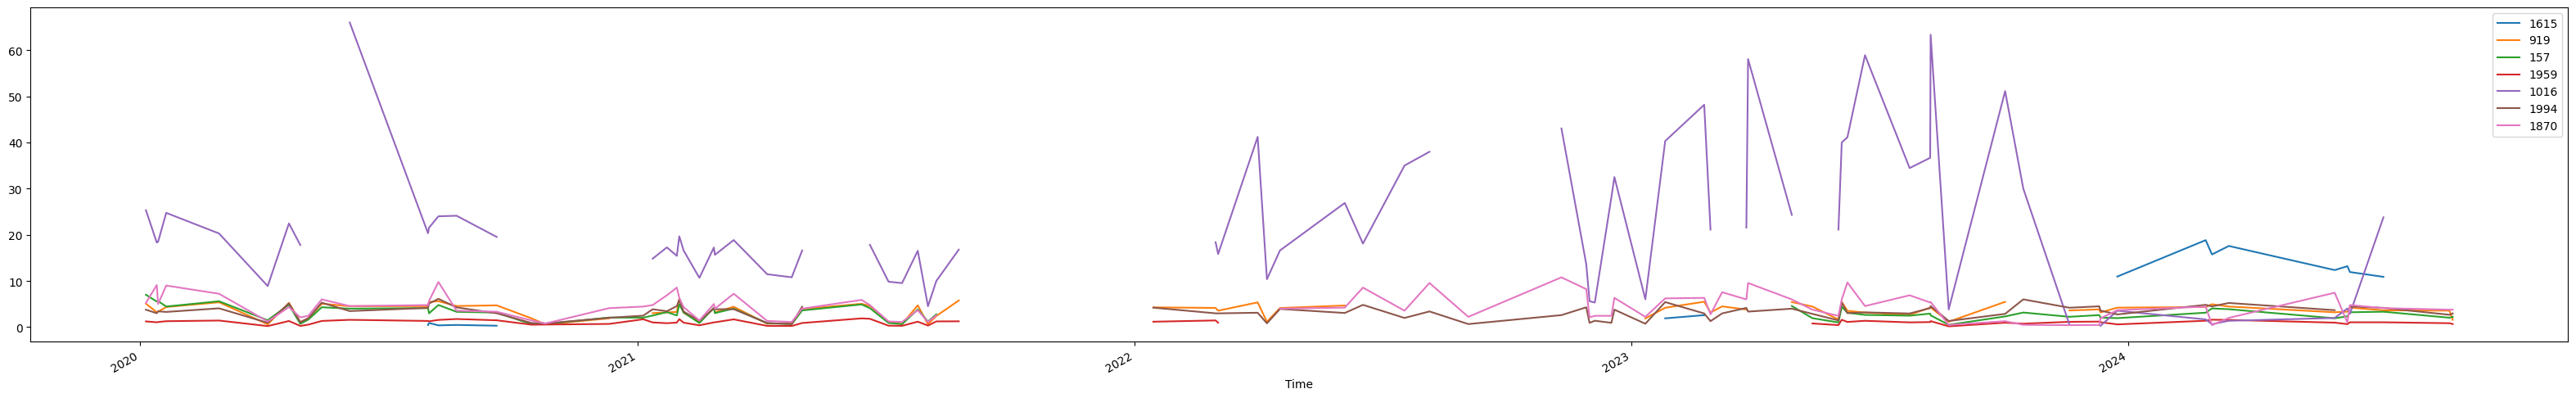

In [ ]:
FLOWDATA_PATH = r"C:\Users\ameli\Documents\Uni\year-3-notes\diss\Dataset\FlowData_for_SubsetGraph_12_with_7SensoredPipes.csv"
SUBSETGRAPH_PATH = r"C:\Users\ameli\Documents\Uni\year-3-notes\diss\Dataset\SubsetGraph_12_with_7SensoredPipes.csv"

df_flowdata = pd.read_csv(FLOWDATA_PATH, index_col=0)
df_flowdata.index = pd.to_datetime(df_flowdata.index, format='%d/%m/%Y %H:%M')

df_subsetgraph = pd.read_c

pd.set_option('display.max_rows', 500)

plotGraph(df_flowdata)


data cleaning

In [ ]:
def find_long_nan_sections(df, max_gap):
    # create a mask for all of the rows with missing values
    missing_vals = df.isna()

    # identify all blocks of missing values
    ###############################################################
    
    prev_row_missing_vals = missing_vals.shift()

    # find the rows where the value of a sensor changes from nan > value, or value > nan
    transition_rows = missing_vals != prev_row_missing_vals

    # assign an id number to each block of vals
    block_ids = transition_rows.cumsum()
    ####################################################################

    # find the length of each gap
    gap_lengths = missing_vals.groupby(block_ids).transform('sum')

    # identify all gaps which are longer than 4 hours
    long_gaps = missing_vals & (gap_lengths > max_gap)

    return long_gaps
    
def find_outlier_values(series):
    rolling_med = series.rolling(window=24, center=True).median()
    diff = (series - rolling_med).abs()
    threshold = 5 * diff.rolling(window=24, center=True).median()
    outlier_mask = diff > threshold
    return outlier_mask

max_gap = 16

df_flowdata = df_flowdata.drop('1615', axis=1)

rows_to_remove = pd.Series(False, index=df_flowdata.index) 
for col in df_flowdata.columns:
    rows_to_remove |= find_long_nan_sections(df_flowdata[col], max_gap)
    rows_to_remove |= find_outlier_values(df_flowdata[col])

df_flowdata = df_flowdata[rows_to_remove == False]



#df_flowdata[gap_mask].head(300)

missing value imputation

In [6]:
df_flowdata.interpolate(
    method='spline',
    order = 3,
)

,919,157,1959,1016,1994,1870
Time,,,,,,
2020-01-01 00:00:00,1.337921,1.847580,0.635989,3.135494,1.060872,1.516347
2020-01-01 00:15:00,1.152680,1.831692,0.569095,3.158890,1.037525,1.466337
2020-01-01 00:30:00,1.296248,1.861493,0.618184,3.171551,1.087439,1.540445
2020-01-01 00:45:00,1.290151,1.849329,0.587787,3.140313,1.193922,1.440362
2020-01-01 01:00:00,1.262242,1.815548,0.624154,3.102092,1.079920,1.440362
...,...,...,...,...,...,...
2024-09-29 21:45:00,1.437727,1.127811,0.504137,2.248950,1.111492,1.299283
2024-09-29 22:00:00,1.383513,0.946928,0.483797,2.333222,1.061257,1.203973
2024-09-29 22:15:00,1.489152,1.017643,0.550046,2.385700,1.038705,1.098612


transformation

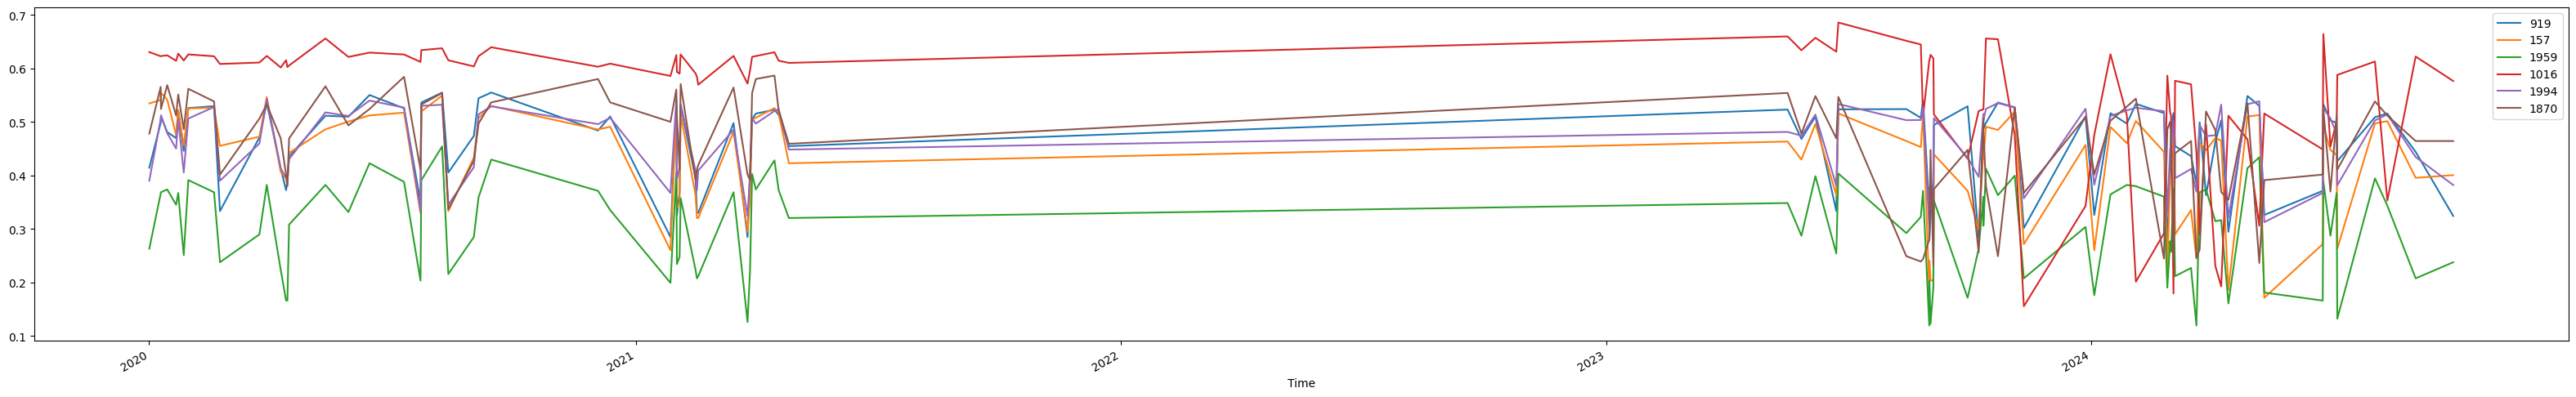

In [9]:
df_flowdata = df_flowdata.apply(np.log1p)
plotGraph(df_flowdata)

stratified random sampling

In [ ]:
strata_dict = {
    'time_of_day': {
        'feature_origin': df_flowdata.index.hour,
        'bins': [0, 6, 12, 14, 18, 22, 24],  
        'labels': ['night', 'morning', 'midday', 'afternoon', 'evening', 'night']
    },
    'part_of_week': {
        'feature_origin': df_flowdata.index.dayofweek,
        'bins': [0, 5, 7], 
        'labels': ['weekday', 'weekend']
    },
    'season': {
        'feature_origin': df_flowdata.index.month,
        'bins': [0, 3, 6, 9, 12, 13], 
        'labels': ['winter', 'spring', 'summer', 'autumn', 'winter']
    }
}

INPUT_WINDOW = 4
FORECAST_WINDOW = 8
TOTAL_WINDOW = INPUT_WINDOW + FORECAST_WINDOW

print(df_flowdata.head(100))

In [ ]:
for strata_name, strata_info in strata_dict.items():
    df_flowdata[strata_name] = pd.cut(
        strata_info['feature_origin'],
        bins=strata_info['bins'],
        labels=strata_info['labels'],
        right=False,  
        include_lowest=True,
        ordered=False
    )

df_flowdata['strata'] = df_flowdata['time_of_day'].astype(str) + '_' + df_flowdata['part_of_week'].astype(str) + '_' + df_flowdata['season'].astype(str)

# Split data into blocks -accounting for gaps in the dataset


gap_mask = df_flowdata.index.to_series().diff() > pd.Timedelta(minutes=15)
df_flowdata['segment_id'] = gap_mask.cumsum()

windows = []
windows_strata = []
for _, segment in df_flowdata.groupby('segment_id'):
    segment = segment.drop(columns='segment_id')

    sensor_values = segment[['919', '157', '1959', '1016', '1994', '1870']].values
    strata_values = segment['strata'].values

    i = 0
    while i + TOTAL_WINDOW <= len(segment):
        windows.append(sensor_values[i: i + TOTAL_WINDOW])
        windows_strata.append(strata_values[i])

        i += TOTAL_WINDOW



['night_weekday_winter', 'night_weekday_winter', 'morning_weekday_winter', 'morning_weekday_winter', 'midday_weekday_winter', 'evening_weekday_winter', 'evening_weekday_winter', 'morning_weekday_winter', 'evening_weekday_winter', 'evening_weekday_winter', 'night_weekday_winter', 'night_weekday_winter', 'evening_weekday_winter', 'evening_weekday_winter', 'night_weekend_winter', 'night_weekend_winter', 'midday_weekend_winter', 'evening_weekend_winter', 'night_weekend_winter', 'night_weekend_winter', 'night_weekend_winter', 'midday_weekend_winter', 'evening_weekend_winter', 'night_weekend_winter', 'night_weekday_winter', 'morning_weekday_winter', 'evening_weekday_winter', 'night_weekday_winter', 'night_weekday_winter', 'morning_weekday_winter', 'afternoon_weekday_winter', 'evening_weekday_winter', 'night_weekday_winter', 'night_weekday_winter', 'morning_weekday_winter', 'midday_weekday_winter', 'evening_weekday_winter', 'evening_weekday_winter', 'night_weekday_winter', 'night_weekday_wint

In [ ]:
for strata_name, strata_info in strata_dict.items():
    df_flowdata[strata_name] = pd.cut(
        strata_info['feature_origin'],
        bins=strata_info['bins'],
        labels=strata_info['labels'],
        right=False,  
        include_lowest=True,
        ordered=False
    )

df_flowdata['strata'] = df_flowdata['time_of_day'].astype(str) + '_' + df_flowdata['part_of_week'].astype(str) + '_' + df_flowdata['season'].astype(str)

# Split data into blocks -accounting for gaps in the dataset


gap_mask = df_flowdata.index.to_series().diff() > pd.Timedelta(minutes=15)
df_flowdata['segment_id'] = gap_mask.cumsum()

windows_df = pd.DataFrame(columns=['window', 'strata'])

for _, segment in df_flowdata.groupby('segment_id'):
    segment = segment.drop(columns='segment_id')

    sensor_values = segment[['919', '157', '1959', '1016', '1994', '1870']].values
    strata_values = segment['strata'].values

    i = 0
    while i + TOTAL_WINDOW <= len(segment):
        windows_df.loc[len(windows_df)] = [
            sensor_values[i:i + TOTAL_WINDOW],
            strata_values[i]
        ]

        i += TOTAL_WINDOW

# Stratified random samplinig!

counts = windows_df['strata'].value_counts()
min_count = counts.min()
sampled = (windows_df.groupby('strata', group_keys=False).sample(n=min_count, random_state=42))

In [ ]:
for strata_name, strata_info in strata_dict.items():
    df_flowdata[strata_name] = pd.cut(
        strata_info['feature_origin'],
        bins=strata_info['bins'],
        labels=strata_info['labels'],
        right=False,  
        include_lowest=True,
        ordered=False
    )

df_flowdata['strata'] = df_flowdata['time_of_day'].astype(str) + '_' + df_flowdata['part_of_week'].astype(str) + '_' + df_flowdata['season'].astype(str)

# Split data into blocks -accounting for gaps in the dataset


gap_mask = df_flowdata.index.to_series().diff() > pd.Timedelta(minutes=15)
df_flowdata['segment_id'] = gap_mask.cumsum()

sensor_cols = ['919', '157', '1959', '1016', '1994', '1870']

windows_df = pd.DataFrame(columns=sensor_cols)
strata_series = pd.Series(dtype='object', name='strata')

for _, segment in df_flowdata.groupby('segment_id'):
    segment = segment.drop(columns='segment_id')

    sensor_values = segment[sensor_cols].values
    strata_values = segment['strata'].values

    i = 0
    while i + TOTAL_WINDOW <= len(segment):
        row = {
            col: sensor_values[i:i + TOTAL_WINDOW, idx]
            for idx, col in enumerate(sensor_cols)
        }

        windows_df.loc[len(windows_df)] = row
        strata_series.loc[len(windows_df)] = strata_values[i]

        i += TOTAL_WINDOW

# Stratified random samplinig!

counts = strata_series.value_counts()
min_count = counts.min()

sampled_idx = (
    strata_series
    .groupby(strata_series)
    .sample(n=min_count, random_state=42)
    .index
)

windows_df_sampled = windows_df.loc[sampled_idx]
strata_series_sampled = strata_series.loc[sampled_idx]

In [ ]:
train_idx, temp_idx = train_test_split(
    windows_df_sampled.index,
    test_size=0.3,
    stratify=strata_series_sampled.loc[windows_df_sampled.index],
    random_state=42
)

train_df = windows_df_sampled.loc[train_idx]
train_strata = strata_series_sampled.loc[train_idx]


val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=strata_series_sampled.loc[temp_idx],
    random_state=42
)

val_df = windows_df_sampled.loc[val_idx]
val_strata = strata_series_sampled.loc[val_idx]

test_df = windows_df_sampled.loc[test_idx]
test_strata = strata_series_sampled.loc[test_idx]

In [ ]:
def load_graph(file_path):
    g = nx.Graph()

    df_subsetgraph = pd.read_csv(file_path)
    df_node_items = df_subsetgraph[df_subsetgraph['SensorIndicator'] == 1]

    for i, row1 in df_node_items.iterrows():
        for j, row2 in df_node_items.iterrows():
            if row1['SensorDMA'] > row2['SensorDMA']:
                g.add_edge(row1['SensorDMA'], row2['SensorDMA'], weight=calc_edge_weight('euclidean', row1, row2))
            
    return g, df_node_items


def calc_edge_weight(technique, row1, row2):
    if technique == 'euclidean':
        return euclidean(row1[['XMid', 'YMid']], row2[['XMid', 'YMid']])
    else:
        raise ValueError(f"Unknown technique: {technique}")
    

def assign_node_indices(g):
    node_list = list(g.nodes)

    node_to_index = {}
    index_to_node = {}

    for i, node in enumerate(node_list):
        node_to_index[node] = i
        index_to_node[i] = node

    return node_to_index, index_to_node


def get_node_features(file_path):
    df = pd.read_csv(file_path, index_col=0)
    x = torch.tensor(df.values, dtype=torch.float).T
    return x

def get_edge_tensors(g, node_to_index):
    indexed_edge_start_nodes = []
    indexed_edge_end_nodes = []
    edge_weights = []

    edge_list = g.edges(data=True)

    for start_node, end_node, weight in edge_list:
        indexed_edge_start_nodes.append(node_to_index[start_node])
        indexed_edge_end_nodes.append(node_to_index[end_node])
        edge_weights.append(weight['weight'])

    edge_index = torch.tensor([indexed_edge_start_nodes, indexed_edge_end_nodes])
    edge_weight = torch.tensor(edge_weights, dtype=torch.long)
    return edge_index, edge_weight

def train_test_split():
    pass


In [ ]:
g, items = load_graph(SUBSETGRAPH_PATH)
node_features = get_node_features(FLOWDATA_PATH)


node_to_index, index_to_node = assign_node_indices(g)
edge_index, edge_weight = get_edge_tensors(g, node_to_index)

data = Data(
    x=node_features,
    edge_index=edge_index,
    edge_weight=edge_weight
)

In [ ]:

def generateNodeMask(minMask, maxMask):
    i = random.randint(minMask, maxMask)
    nodesToMask = random.sample(range(7), i)
    return nodesToMask

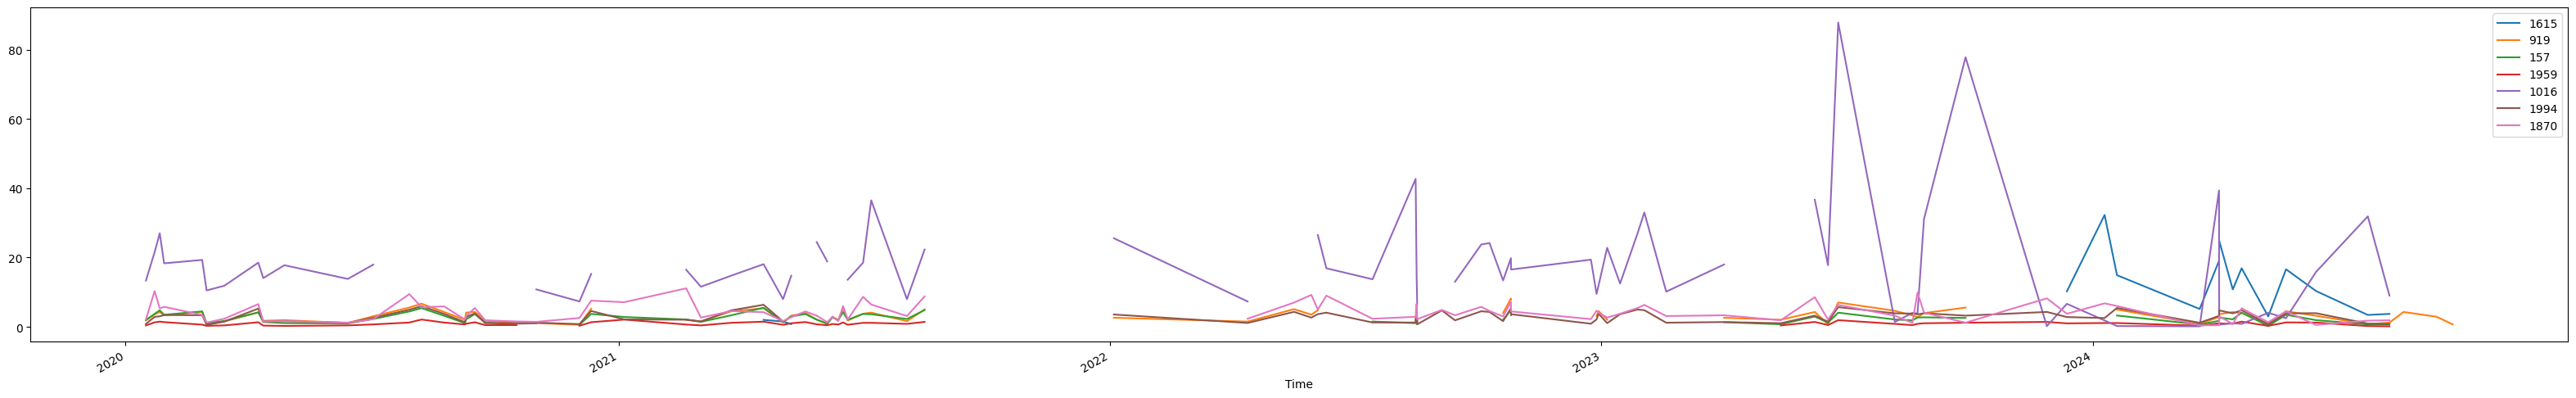

,919,157,1959,1016,1994,1870
883,"[1.916922640270296, 1.8155483347002073, 1.8870...","[1.596014905007365, 1.6248736902794754, 1.5475...","[0.9469277343963891, 0.7312989875403635, 0.715...","[2.966036406094439, 2.955353834814991, 2.94455...","[1.6550484723485719, 1.6379173879460338, 1.607...","[1.6094379124341003, 1.5639755660317614, 1.466..."
947,"[1.1314021576201316, 1.0874389986317823, 0.989...","[1.0335797906106936, 0.9932518789362038, 0.798...","[0.6819738805797976, 0.6000567634085675, 0.659...","[2.0252198967507296, 2.0134203535345603, 2.001...","[1.1169614359908517, 1.0761394545205965, 0.893...","[1.0608719835698779, 1.0986122886681098, 1.299..."
2026,"[0.6000567634085675, 0.569094556418268, 0.5436...","[0.1915382448346579, 0.33647227804978347, 0.22...","[0.11531084631297459, 0.11531084631297459, 0.1...","[2.6625878177231272, 2.6625878177231272, 2.662...","[0.6354003727678684, 0.6740776161974655, 0.618...","[0.3867729864922382, 0.36464311219902035, 0.35..."
2146,"[1.6465196139553342, 1.6335884120590074, 1.678...","[1.3694871982272372, 1.3609765774945748, 1.249...","[0.8520484923875071, 0.7312989875403635, 0.773...","[3.6841460371505192, 3.704315252096073, 3.6448...","[1.4911547820762043, 1.5040773967762742, 1.413...","[0.4179790747895437, 1.200299426326639, 0.6780..."
2101,"[0.6534819422599993, 0.606135825206679, 0.6121...","[0.30421141899315446, 0.25378061706919836, 0.2...","[0.11531084631297459, 0.11531084631297459, 0.1...","[1.2731878828030854, 1.3434448607751859, 1.398...","[0.6706743259578868, 0.6085571205422763, 0.620...","[0.38978731051308796, 0.3875274248423114, 0.38..."
2140,"[1.7087804095088168, 1.589235224504336, 1.6049...","[1.3552621998377767, 1.299283103402981, 1.3291...","[0.9469277343963891, 0.7833940666818351, 0.681...","[1.8009762018559117, 1.667706649425986, 1.7692...","[1.682688395363284, 1.7586239671648793, 1.6785...","[1.0288254492148505, 0.7205461676129246, 0.728..."
2052,"[1.652923044629158, 1.6049835982900766, 1.6138...","[0.3753877163823348, 0.41284529408225445, 0.33...","[0.2363887893800198, 0.2363887893800198, 0.236...","[1.0414538835340434, 1.0414538941222784, 1.037...","[0.8819293211001741, 0.8969946452885651, 0.783...","[1.2367626194715073, 0.8938178652039146, 0.980..."
2138,"[0.49740261654195805, 0.5371429419534939, 0.51...","[0.12516313560106482, 0.20972059233341853, 0.4...","[0.24512246838081103, 0.2275781598865002, 0.30...","[0.4489502272819458, 0.4560173937498689, 0.448...","[0.5532463569662367, 0.6265324549340181, 0.651...","[0.3388503609264179, 0.33964181961034007, 0.33..."
394,"[1.2495833414060133, 1.0949017394202725, 1.001...","[1.3638215980519186, 1.2205021434902608, 1.252...","[0.5240708612396956, 0.42017125469494015, 0.49...","[2.650107145629159, 2.511404296551211, 2.56323...","[1.203972851925935, 1.31133131129913, 1.176944...","[1.3581234705531942, 1.0216512522919814, 1.060..."
437,"[0.856776595190804, 0.7833940666818351, 0.7205...","[0.8938179384311854, 0.842524631060382, 0.8425...","[0.26236427369826026, 0.16362942736670774, 0.2...","[2.6508917620857906, 2.511404273016494, 2.6149...","[0.9469277343963891, 0.8754687273538998, 0.793...","[0.8938178652039146, 0.8472978773872035, 0.798..."


In [8]:
def plotGraph(df):
    df_sample = df.sample(n=96).sort_index()

    df_sample.plot(
        figsize=(40, 6),
        sharex=True
    )
    plt.show()


#================================================
# Node feature preprocessing
#==================================

def find_long_nan_sections(df, max_gap):
    # create a mask for all of the rows with missing values
    missing_vals = df.isna()

    # identify all blocks of missing values
    ###############################################################
    
    prev_row_missing_vals = missing_vals.shift()

    # find the rows where the value of a sensor changes from nan > value, or value > nan
    transition_rows = missing_vals != prev_row_missing_vals

    # assign an id number to each block of vals
    block_ids = transition_rows.cumsum()
    ####################################################################

    # find the length of each gap
    gap_lengths = missing_vals.groupby(block_ids).transform('sum')

    # identify all gaps which are longer than 4 hours
    long_gaps = missing_vals & (gap_lengths > max_gap)

    return long_gaps
    
def find_outlier_values(series):
    rolling_med = series.rolling(window=24, center=True).median()
    diff = (series - rolling_med).abs()
    threshold = 5 * diff.rolling(window=24, center=True).median()
    outlier_mask = diff > threshold
    return outlier_mask

def assign_strata(df_flowdata):

    strata_dict = {
        'time_of_day': {
            'feature_origin': df_flowdata.index.hour,
            'bins': [0, 6, 12, 14, 18, 22, 24],  
            'labels': ['night', 'morning', 'midday', 'afternoon', 'evening', 'night']
        },
        'part_of_week': {
            'feature_origin': df_flowdata.index.dayofweek,
            'bins': [0, 5, 7], 
            'labels': ['weekday', 'weekend']
        },
        'season': {
            'feature_origin': df_flowdata.index.month,
            'bins': [0, 3, 6, 9, 12, 13], 
            'labels': ['winter', 'spring', 'summer', 'autumn', 'winter']
        }
    }

    for strata_name, strata_info in strata_dict.items():
        df_flowdata[strata_name] = pd.cut(
            strata_info['feature_origin'],
            bins=strata_info['bins'],
            labels=strata_info['labels'],
            right=False,  
            include_lowest=True,
            ordered=False
        )

    df_flowdata['strata'] = df_flowdata['time_of_day'].astype(str) + '_' + df_flowdata['part_of_week'].astype(str) + '_' + df_flowdata['season'].astype(str)

    return df_flowdata


def create_samples(df_flowdata):

    gap_mask = df_flowdata.index.to_series().diff() > pd.Timedelta(minutes=15)
    df_flowdata['segment_id'] = gap_mask.cumsum()

    sensor_cols = ['919', '157', '1959', '1016', '1994', '1870']

    windows_df = pd.DataFrame(columns=sensor_cols)
    strata_series = pd.Series(dtype='object', name='strata')

    for _, segment in df_flowdata.groupby('segment_id'):
        segment = segment.drop(columns='segment_id')

        sensor_values = segment[sensor_cols].values
        strata_values = segment['strata'].values

        i = 0
        while i + TOTAL_WINDOW <= len(segment):
            row = {
                col: sensor_values[i:i + TOTAL_WINDOW, idx]
                for idx, col in enumerate(sensor_cols)
            }

            windows_df.loc[len(windows_df)] = row
            strata_series.loc[len(windows_df)] = strata_values[i]

            i += TOTAL_WINDOW

    return windows_df, strata_series
    
def strat_random_sampling(windows_df, strata_series):
    counts = strata_series.value_counts()
    min_count = counts.min()

    sampled_idx = strata_series.groupby(strata_series).sample(n=min_count, random_state=42).index

    windows_df_sampled = windows_df.loc[sampled_idx]
    strata_series_sampled = strata_series.loc[sampled_idx]

    return windows_df_sampled, strata_series_sampled


def preprocess_flowdata(df_flowdata):

    df_flowdata = df_flowdata.drop('1615', axis=1)

    rows_to_remove = pd.Series(False, index=df_flowdata.index) 
    for col in df_flowdata.columns:
        rows_to_remove |= find_long_nan_sections(df_flowdata[col], MAX_GAP)
        rows_to_remove |= find_outlier_values(df_flowdata[col])

    df_flowdata = df_flowdata[rows_to_remove == False]

    df_flowdata = df_flowdata.interpolate(method='spline', order = 3)

    df_flowdata = df_flowdata.apply(np.log1p)

    df_flowdata = assign_strata(df_flowdata)

    windows_df, strata_series = create_samples(df_flowdata)

    windows_df_sampled, strata_series_sampled = strat_random_sampling(windows_df, strata_series)

    
    #df = pd.read_csv(file_path, index_col=0)
    #x = torch.tensor(df.values, dtype=torch.float).T

    return windows_df_sampled, strata_series_sampled


FLOWDATA_PATH = r"C:\Users\ameli\Documents\Uni\year-3-notes\diss\Dataset\FlowData_for_SubsetGraph_12_with_7SensoredPipes.csv"
SUBSETGRAPH_PATH = r"C:\Users\ameli\Documents\Uni\year-3-notes\diss\Dataset\SubsetGraph_12_with_7SensoredPipes.csv"


df_flowdata = pd.read_csv(FLOWDATA_PATH, index_col=0)
df_flowdata.index = pd.to_datetime(df_flowdata.index, format='%d/%m/%Y %H:%M')

pd.set_option('display.max_rows', 500)

plotGraph(df_flowdata)



INPUT_WINDOW = 4
FORECAST_WINDOW = 8
TOTAL_WINDOW = INPUT_WINDOW + FORECAST_WINDOW
MAX_GAP = 16



windows_df_sampled, strata_series_sampled = preprocess_flowdata(df_flowdata)

windows_df_sampled.head(100)

In [11]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import euclidean
import torch
from sklearn.model_selection import train_test_split
from eda import plotGraph




pd.set_option('display.max_rows', 500)

INPUT_WINDOW = 4
FORECAST_WINDOW = 8
TOTAL_WINDOW = INPUT_WINDOW + FORECAST_WINDOW
MAX_GAP = 16
SENSOR_COLS = ['919', '157', '1959', '1016', '1994', '1870']

FLOWDATA_PATH = r"C:\Users\ameli\Documents\Uni\year-3-notes\diss\Dataset\FlowData_for_SubsetGraph_12_with_7SensoredPipes.csv"
SUBSETGRAPH_PATH = r"C:\Users\ameli\Documents\Uni\year-3-notes\diss\Dataset\SubsetGraph_12_with_7SensoredPipes.csv"

In [15]:


def find_long_nan_sections(df, max_gap):
    # create a mask for all of the rows with missing values
    missing_vals = df.isna()
    
    prev_row_missing_vals = missing_vals.shift()

    # find the rows where the value of a sensor changes from nan > value, or value > nan
    transition_rows = missing_vals != prev_row_missing_vals

    # assign an id number to each block of vals
    block_ids = transition_rows.cumsum()

    # find the length of each gap
    gap_lengths = missing_vals.groupby(block_ids).transform('sum')

    # identify all gaps which are longer than 4 hours
    long_gaps = missing_vals & (gap_lengths > max_gap)

    return long_gaps
    
def find_outlier_values(series):
    rolling_med = series.rolling(window=24, center=True).median()
    diff = (series - rolling_med).abs()
    threshold = 5 * diff.rolling(window=24, center=True).median()
    outlier_mask = diff > threshold
    return outlier_mask

def assign_strata(df_flowdata):

    strata_dict = {
        'time_of_day': {
            'feature_origin': df_flowdata.index.hour,
            'bins': [0, 6, 12, 14, 18, 22, 24],  
            'labels': ['night', 'morning', 'midday', 'afternoon', 'evening', 'night']
        },
        'part_of_week': {
            'feature_origin': df_flowdata.index.dayofweek,
            'bins': [0, 5, 7], 
            'labels': ['weekday', 'weekend']
        },
        'season': {
            'feature_origin': df_flowdata.index.month,
            'bins': [0, 3, 6, 9, 12, 13], 
            'labels': ['winter', 'spring', 'summer', 'autumn', 'winter']
        }
    }



    for strata_name, strata_info in strata_dict.items():
        df_flowdata[strata_name] = pd.cut(
            strata_info['feature_origin'],
            bins=strata_info['bins'],
            labels=strata_info['labels'],
            right=False,  
            include_lowest=True,
            ordered=False
        )

    df_flowdata['strata'] = df_flowdata['time_of_day'].astype(str) + '_' + df_flowdata['part_of_week'].astype(str) + '_' + df_flowdata['season'].astype(str)

    return df_flowdata


def create_samples(df_flowdata):

    gap_mask = df_flowdata.index.to_series().diff() > pd.Timedelta(minutes=15)
    df_flowdata['segment_id'] = gap_mask.cumsum()

    

    windows_df = pd.DataFrame(columns=SENSOR_COLS)
    strata_series = pd.Series(dtype='object', name='strata')

    for _, segment in df_flowdata.groupby('segment_id'):
        segment = segment.drop(columns='segment_id')

        sensor_values = segment[SENSOR_COLS].values
        strata_values = segment['strata'].values

        i = 0
        while i + TOTAL_WINDOW <= len(segment):
            row = {
                col: sensor_values[i:i + TOTAL_WINDOW, idx]
                for idx, col in enumerate(SENSOR_COLS)
            }

            windows_df.loc[len(windows_df)] = row
            strata_series.loc[len(windows_df)] = strata_values[i]

            i += TOTAL_WINDOW

    return windows_df, strata_series
    
def strat_random_sampling(windows_df, strata_series):
    counts = strata_series.value_counts()
    min_count = counts.min()

    sampled_idx = strata_series.groupby(strata_series).sample(n=min_count, random_state=42).index

    windows_df_sampled = windows_df.loc[sampled_idx]
    strata_series_sampled = strata_series.loc[sampled_idx]

    return windows_df_sampled, strata_series_sampled


def train_val_test_split(windows_df_sampled, strata_series_sampled):

    train_idx, temp_idx = train_test_split(
        windows_df_sampled.index,
        test_size=0.3,
        stratify=strata_series_sampled.loc[windows_df_sampled.index],
        random_state=42
    )

    train_df = windows_df_sampled.loc[train_idx]
    train_strata = strata_series_sampled.loc[train_idx]

    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=0.5,
        stratify=strata_series_sampled.loc[temp_idx],
        random_state=42
    )

    val_df = windows_df_sampled.loc[val_idx]
    val_strata = strata_series_sampled.loc[val_idx]

    test_df = windows_df_sampled.loc[test_idx]
    test_strata = strata_series_sampled.loc[test_idx]

    
    return [train_df, train_strata, val_df], [val_strata, test_df, test_strata]


def preprocess_flowdata(path):

    # Reading in the flow data file
    df_flowdata = pd.read_csv(path, index_col=0)
    df_flowdata.index = pd.to_datetime(df_flowdata.index, format='%d/%m/%Y %H:%M')

    # Removing a sensor with a large number of missing values
    df_flowdata = df_flowdata.drop('1615', axis=1)

    # Removing rows which have outliers or are part of long sections of missing values
    rows_to_remove = pd.Series(False, index=df_flowdata.index) 
    for col in df_flowdata.columns:
        rows_to_remove |= find_long_nan_sections(df_flowdata[col], MAX_GAP)
        rows_to_remove |= find_outlier_values(df_flowdata[col])
    df_flowdata = df_flowdata[rows_to_remove == False]

    # Imputing short ranges of missing values
    df_flowdata = df_flowdata.interpolate(method='spline', order = 3)

    # Applying a transformation
    df_flowdata = df_flowdata.apply(np.log1p)

    # Stratified random sampling
    df_flowdata = assign_strata(df_flowdata)
    windows_df, strata_series = create_samples(df_flowdata)
    windows_df_sampled, strata_series_sampled = strat_random_sampling(windows_df, strata_series)

    # Splitting into train val and test sets
    split_df, split_df_strata = train_val_test_split(windows_df_sampled, strata_series_sampled)
   
    return split_df, split_df_strata





In [16]:
df_node_features, df_node_features_strata = preprocess_flowdata(FLOWDATA_PATH)

In [14]:
print()

df_node_features.head() 
df_node_features_strata.head()

AttributeError: 'str' object has no attribute 'head'

In [17]:
import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data

class WaterFlowDataSet(Dataset):

    def __init__(self, df, df_strata, edge_index, edge_weight, forecast_window=0):
        self.df = df
        self.df_strata = df_strata
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        #self.T = num_timesteps
        #self.mask_prob_nodes = mask_prob_nodes
        self.forecast_window = forecast_window
        self.node_names = list(df.columns)
        self.N = len(self.node_names)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        #TODO: is this tensor the right way round or should i .T it
        row = self.df.loc[idx, self.node_names]
        x = torch.tensor(row.values, dtype=torch.float)

        mask = self.generate_mask(x)
        x_masked = x * mask

        #edge_index_tensor = torch.tensor(self.edge_index)
        #edge_weight_tensor = torch.tensor(self.edge_weight, dtype=torch.long)

        data = Data(
            x = x_masked,
            y = x,       
            mask = mask,            
            edge_index = self.edge_index,
            edge_weight = self.edge_weight
        )
        return data
    
    def generate_mask(self, x):

        mask = torch.ones_like(x)

        num_nodes_to_mask = torch.randint(1, 4, (1,)).item()
        node_indices = torch.randperm(self.N)[:num_nodes_to_mask]
        mask[node_indices, :] = 0.0  

        if self.forecast_window > 0:
            mask[:, -self.forecast_window:] = 0.0

        return mask
